In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import product

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

In [210]:
from matplotlib import colors

class CyclicNormalize(colors.Normalize):
    def __init__(self, cmin=0, cmax=2*np.pi, vmin=0, vmax=1, clip=False):
        self.cmin = cmin
        self.cmax = cmax
        colors.Normalize.__init__(self, vmin, vmax, clip=clip)

    def __call__(self, value, clip=False):
        x, y = [self.cmin, self.cmax], [0, 1]
        return np.ma.masked_array(np.interp(value, x, y, period=self.cmax - self.cmin))

cmap = plt.cm.viridis

cyclicnorm = CyclicNormalize(cmin=0, cmax=2*np.pi, vmin=0, vmax=20)


In [292]:
inc = np.arange(30, 65, 1)
den = np.arange(100, 320, 5)
hn = np.arange(0, 0.53, 0.01)*100
swe = np.zeros(den.size*hn.size*inc.size)
phases = np.zeros(den.size*hn.size*inc.size)
for j, (h, d, i) in enumerate(product(hn, den, inc)):
    
    # swe[i] = hn/100*d/997
    phases[j] = phase_from_depth(h/100, np.deg2rad(i), density=d)

# hn_shift = (hn[2]-hn[1])/2
# inc_shift = (inc[2]-inc[1])/2
# den_shift = (den[2]-den[1])/2
# Z = phases.reshape(hn.size, den.size)
# plt.imshow(Z, extent= [den.min()-den_shift, den.max()+den_shift, hn.max()+hn_shift, hn.min()-hn_shift], aspect = 'auto', cmap = 'viridis', norm=cyclicnorm)
# # plt.colorbar(label = 'phase (radians)')
# plt.contour(den, hn, Z, [np.pi], color = '')

# plt.xlabel('density (kg/m3)')
# plt.ylabel('Snow Depth Increase (cm)')

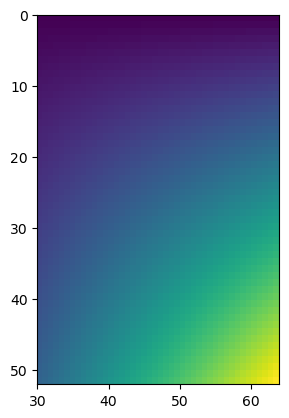

In [307]:
plt.imshow(data[:,:,0], extent = [inc.min(), inc.max(), hn.max(), hn.min()])

In [293]:
data = phases.reshape(hn.size, den.size, inc.size)
X, Y, Z = np.meshgrid(hn, den, inc)

print(X.shape)
print(Y.shape)
print(Z.shape)
print(data.shape)

(44, 53, 35)
(44, 53, 35)
(44, 53, 35)
(53, 44, 35)


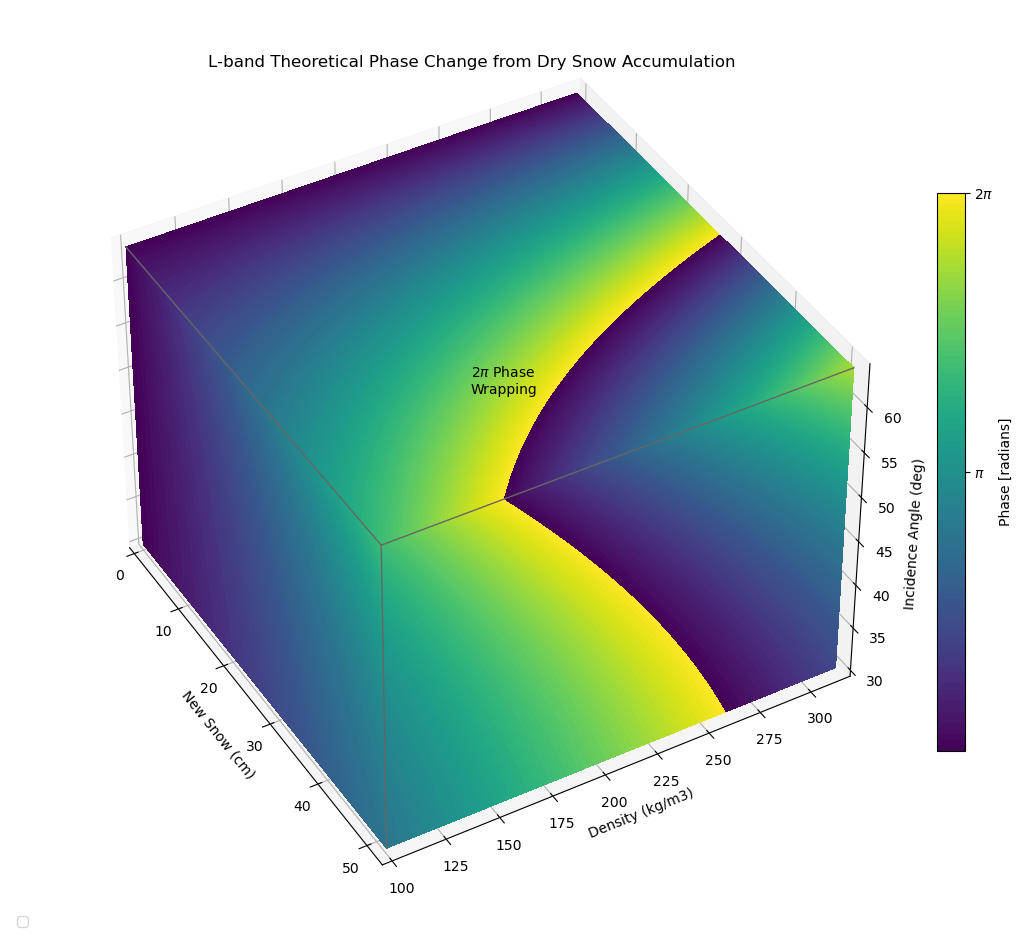

In [388]:
kw = {
    'vmin': 0,
    'vmax': 2*np.pi,
    
    'levels': np.linspace(0, 2*np.pi, 100),
    'cmap':'viridis'
}
kw2 = {
    'vmin': 2*np.pi,
    'vmax': 4*np.pi,
    
    'levels': np.linspace(2*np.pi,4*np.pi, 100),
    'cmap':'viridis'
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
# surface on top of box
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw
)
_ = ax.contourf(
    X[:, :, -1], Y[:, :, 0], data[:, :, -1].T,
    zdir='z', offset=Z.max(), **kw2
)
# _ = ax.contour(
#     X[:, :, -1], Y[:, :, 0], data[:, :, -1].T, [2* np.pi],
#     zdir='z', offset=Z.max(), colors= ['C1'], linestyles = 'dashed'
# )
# y and z axis side
_ = ax.contourf(
    X[0, :, :], data[:, 0, :], Z[0, :, :],
    zdir='y', offset=Y.min(), **kw
)

C = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
_ = ax.contourf(
    data[-1, :, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw2
)
# _ = ax.contour(
#     data[-1, :, :], Y[:, -1, :], Z[:, -1, :], [2* np.pi],
#     zdir='x', offset=X.max(), colors= ['C1'], linestyles = 'dashed'
# )

# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(linewidth=1, zorder=1e3, color = '0.4')
# line @ z = 0 along y axis
# ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
# line @ z = 0 along x axis
# ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
# line @ x max and y min along z axis
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
# ax.plot([0,0],[0,0],[0,0], label = '2$\pi$ Wrap', color = 'C1', linestyle = 'dashed')

# Set labels and zticks
ax.set(
    xlabel='New Snow (cm)',
    ylabel='Density (kg/m3)',
    zlabel='Incidence Angle (deg)',
    # zticks=[0, -150, -300, -450],
)

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_box_aspect(None, zoom=0.91)
ax.legend(loc = 'lower left')
# Colorbar
cbar = fig.colorbar(C, ax=ax, fraction=0.02, pad=0.002, label='Phase [radians]', ticks=[np.pi, 2*np.pi, 3*np.pi])
cbar.ax.set_yticklabels(['$\pi$', '2$\pi$','3$\pi$'])
# plt.tight_layout()
# Show Figure
ax.text(s = '$2\pi$ Phase\nWrapping', x = 37, y = 175, z = zmax, zorder = 1e3, weight = None)

plt.title('L-band Theoretical Phase Change from Dry Snow Accumulation', y = 1.01)
plt.savefig('/bsuhome/zacharykeskinen/uavsar-validation/figures/theoretical/l-band-phase-sd.png')